# MODEL TRAINING

## 1. Importing data and required packages

#### 1.1 import modeules

In [1]:
# Basic import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Column Transformers
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# separate dataset into train & test
from sklearn.model_selection import train_test_split

#### 1.2 import cleaned data as pandas dataframe

In [2]:
car_data = pd.read_csv('data/cleaned_car_data.csv', index_col=0)

In [3]:
car_data

,name,company,year,Price,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,80000,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,425000,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,325000,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,575000,36000,Diesel
4,Ford Figo,Ford,2012,175000,41000,Diesel
...,...,...,...,...,...,...
810,Maruti Suzuki Ritz,Maruti,2011,270000,50000,Petrol
811,Tata Indica V2,Tata,2009,110000,30000,Diesel
812,Toyota Corolla Altis,Toyota,2009,300000,132000,Petrol
813,Tata Zest XM,Tata,2018,260000,27000,Diesel


## 2. Preparation of Model

#### 2.1 Preparing x & y variables

In [4]:
x = car_data.drop(columns=['Price'], axis=1)
y = car_data['Price']

In [5]:
x.head()

,name,company,year,kms_driven,fuel_type
0,Hyundai Santro Xing,Hyundai,2007,45000,Petrol
1,Mahindra Jeep CL550,Mahindra,2006,40,Diesel
2,Hyundai Grand i10,Hyundai,2014,28000,Petrol
3,Ford EcoSport Titanium,Ford,2014,36000,Diesel
4,Ford Figo,Ford,2012,41000,Diesel


In [6]:
y.head()

0     80000
1    425000
2    325000
3    575000
4    175000
Name: Price, dtype: int64

#### 2.2 training & testing dataset preparation

In [7]:
numeric_features = [feature for feature in x.columns if x[feature].dtype != 'O']
categorical_features = [feature for feature in x.columns if x[feature].dtype == 'O']

print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 2 numerical features : ['year', 'kms_driven']

We have 3 categorical features : ['name', 'company', 'fuel_type']


In [8]:
numeric_transformer = StandardScaler()
ohe_transformer = OneHotEncoder()

In [9]:
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", ohe_transformer, categorical_features),
        ("StandardScaler", numeric_transformer, numeric_features)
    ]
)

In [10]:
X = preprocessor.fit_transform(x)
X.shape

(815, 284)

#### 2.3 Model calculations

In [11]:
def model_R2_calc(rnd_stt):
    """
    This function calculates r2_score using 9 different models.
    It takes input "rnd_stt" as "random_state".
    It starts from 0 to (rand_state - 1).
    In the return, it gives - "new_rand_state - best random state", 
    "new_model_list - list of best models to use at that random state", 
    "new_r2_train_list - best r2 score of train model w.r.t. that best random state & model", 
    "new_r2_test_list - bestr2 score of test model w.r.t. that best random state & model".
    """
    
    rand_state = []
    model_list = []
    r2_train_list =[]
    r2_test_list =[]

    for i in range(rnd_stt):
        x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=i)
        
        models = {
            "Linear Regression": LinearRegression(),
            #"Lasso": Lasso(max_iter=10000),
            "Ridge": Ridge(),
            "K-Neighbors Regressor": KNeighborsRegressor(),
            "Decision Tree": DecisionTreeRegressor(),
            "Random Forest Regressor": RandomForestRegressor(),
            "XGBRegressor": XGBRegressor(), 
            "CatBoosting Regressor": CatBoostRegressor(verbose=False),
            "AdaBoost Regressor": AdaBoostRegressor()
            }


        for j in range(len(list(models))):
            model = list(models.values())[j]
            model.fit(x_train, y_train) # Train model

            # Make predictions
            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            
            # Evaluate Train and Test dataset
            model_train_r2 = r2_score(y_train, y_train_pred)
            model_test_r2 = r2_score(y_test, y_test_pred)
            
            rand_state.append(i)
            model_list.append(list(models.keys())[j])
            r2_train_list.append(round(model_train_r2, 4))
            r2_test_list.append(round(model_test_r2, 4))
    
    new_rand_state = []
    new_model_list = []
    new_r2_train_list =[]
    new_r2_test_list =[]

    for k in range(len(rand_state)):
        if (abs(r2_train_list[k] - r2_test_list[k]) < 0.1) and (r2_test_list[k] > 0.8):
            new_rand_state.append(rand_state[k])
            new_model_list.append(model_list[k])
            new_r2_train_list.append(r2_train_list[k])
            new_r2_test_list.append(r2_test_list[k])

    return new_rand_state, new_model_list, new_r2_train_list, new_r2_test_list

In [12]:
rand_state, model_list, r2_train_list, r2_test_list = model_R2_calc(200)


In [13]:
model_data = {
                'model_name': model_list, 
                "random_state":rand_state, 
                'r2_train':r2_train_list, 
                'r2_test': r2_test_list
            }
pd.DataFrame(model_data).sort_values(by=["r2_test"],ascending=False).reset_index(drop=True)

,model_name,random_state,r2_train,r2_test
0,XGBRegressor,124,0.9744,0.9104
1,XGBRegressor,4,0.9767,0.8998
2,Linear Regression,124,0.9437,0.8895
3,Random Forest Regressor,4,0.9428,0.8828
4,Ridge,124,0.8881,0.8799
5,Random Forest Regressor,172,0.9477,0.8769
6,CatBoosting Regressor,172,0.9409,0.8767
7,Random Forest Regressor,124,0.9500,0.8765
8,CatBoosting Regressor,124,0.9442,0.8733
9,Linear Regression,172,0.9444,0.8718


#### 2.4 Model Selection
- From the above r2 score table, selecting **Linear Regressor** as model.
- As difference between r2 score of train data & test data is less than **0.6**.

#### 2.5 Checking Linear Regressor for another 1000 iteration for best random state

In [14]:
rand_state_ = []
r2_train_list_ =[]
r2_test_list_ =[]

for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=i)
    
    lr = LinearRegression()

    lr.fit(x_train, y_train) # Train model

    # Make predictions
    y_train_pred = lr.predict(x_train)
    y_test_pred = lr.predict(x_test)
    
    # Evaluate Train and Test dataset
    model_train_r2 = r2_score(y_train, y_train_pred)

    model_test_r2 = r2_score(y_test, y_test_pred)
    
    rand_state_.append(i)
    r2_train_list_.append(round(model_train_r2, 4))
    r2_test_list_.append(round(model_test_r2, 4))

In [15]:
new_rand_state_ = []
new_r2_train_list_ =[]
new_r2_test_list_ =[]
for k in range(len(rand_state_)):
    if (abs(r2_train_list_[k] - r2_test_list_[k]) < 0.1) and (r2_test_list_[k] > 0.8):
        new_rand_state_.append(rand_state_[k])
        new_r2_train_list_.append(r2_train_list_[k])
        new_r2_test_list_.append(r2_test_list_[k])

lr_model_r2 = {
                'rand_state':new_rand_state_, 
                'r2_train':new_r2_train_list_, 
                'r2_test':new_r2_test_list_,
                }
lr_model = pd.DataFrame(lr_model_r2).sort_values(by=['r2_test'], ascending=False).reset_index(drop=True)

In [16]:
lr_model['difference'] = abs(lr_model['r2_train'] - lr_model['r2_test'])
lr_model

,rand_state,r2_train,r2_test,difference
0,124,0.9437,0.8895,0.0542
1,661,0.9435,0.8893,0.0542
2,279,0.9459,0.8765,0.0694
3,686,0.9381,0.8725,0.0656
4,172,0.9444,0.8718,0.0726
5,515,0.9487,0.8703,0.0784
6,652,0.9423,0.8689,0.0734
7,443,0.9469,0.8678,0.0791
8,351,0.9465,0.8640,0.0825
9,327,0.9459,0.8638,0.0821


#### 2.6 Selecting best random state
- As from above, we are going to select **Linear Regression** model at **random state = 124**.


## 3. Model - Linear Regression

#### 3.1 Training Linear Regression Model

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=124)
lr = LinearRegression()
lr.fit(x_train, y_train)

# Make predictions
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

# Evaluate Train and Test dataset
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

0.9437008922572205
0.8894615329200459


#### 3.2 Plot y_predicted vs y_test

Text(0, 0.5, 'Predicted')

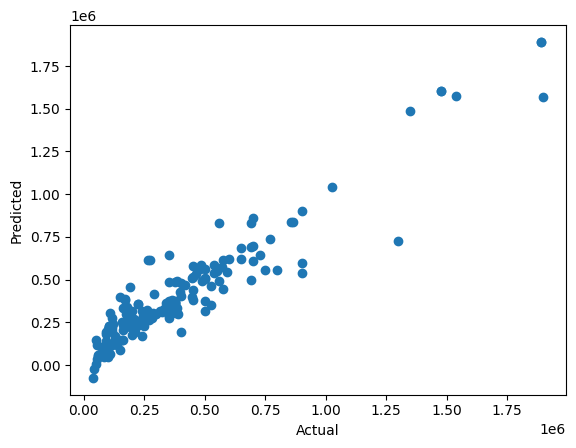

In [18]:
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

<Axes: xlabel='Price'>

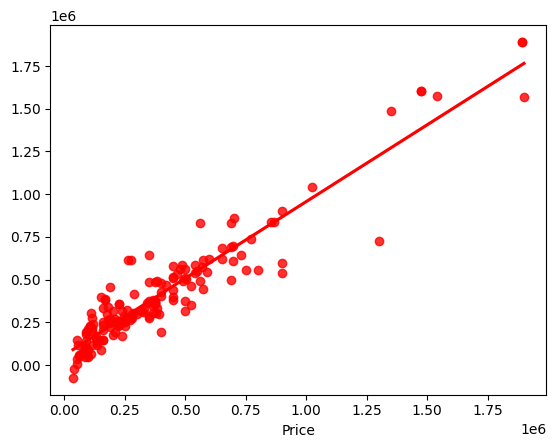

In [19]:
sns.regplot(x=y_test, y=y_test_pred, ci=None, color='red')

#### 3.3 Difference Between Actual & Predicted Values

In [20]:
pd.DataFrame({'Actual Value':y_test, 'Predicted Value':y_test_pred, 'Difference':(y_test-y_test_pred)})

,Actual Value,Predicted Value,Difference
664,499000,374013.490528,124986.509472
603,600000,621597.288803,-21597.288803
691,99000,211122.622039,-112122.622039
374,330000,326547.447805,3452.552195
33,650000,621348.672087,28651.327913
...,...,...,...
808,250000,228336.584998,21663.415002
276,540000,539997.350014,2.649986
544,280000,275578.741495,4421.258505
504,340000,364203.114718,-24203.114718


## 4. Saving Trained and Testd Model - Linear Regressor

In [21]:
import pickle
path = "D:/All Files/Data Science/3. ML Projects/Car_Price_Predictor/model/"
pickle.dump(lr, open((path + "car_price_pred_Model.pkl"), 'wb'))